In [1]:
import os
import pickle
import sys
import numpy as np
import scipy
import scipy.io
import math
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

In [2]:
if not os.path.exists('qm7.mat'):
    os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

## Modeling

In [3]:
class EigenSpectrum:
    def __init__(self, total_atom = 23):
        self.total_atom = total_atom
        self.max_num_atom = 1
        
    def extract_compact_mol(self, z):
        index =  np.where(~z.any(axis=0))[0]
        A = np.delete(z, index, axis = 0)
        A = np.delete(A, index, axis = 1)
        return A 
    
    def featurize(self, z):
        eigs, _ = np.linalg.eig(z)
        eigs = sorted(eigs, key=lambda value: np.abs(value))
        feature = eigs[::-1]
        
        if self.max_num_atom > z.shape[0]:
            feature = np.zeros(self.max_num_atom)
            feature[:z.shape[0]] = eigs
        
        return feature
    
    def process(self, X):
        comp_mols = []
        for z in X:
            comp_z = self.extract_compact_mol(z)
            if self.max_num_atom < comp_z.shape[0]:
                self.max_num_atom = comp_z.shape[0]
            comp_mols.append(comp_z)
            
        features = np.array([self.featurize(z) for z in comp_mols])
        return features

In [9]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    mse = np.square(np.subtract(y_true,y_pred)).mean() 
    return math.sqrt(mse)

In [12]:
def cross_validation(dataset, featurizer):
    mae_scores = []
    rmse_scores = []
    for split in [0,1,2,3,4]:
        best_mae_score = 1000
        best_rmse_score = 1000
        best_sigma = -1
        best_alpha = 0
        P_train = dataset['P'][list(range(0, split))+list(range(split+1, 5))].flatten()
        P_test = dataset['P'][split]
    
        X_train = dataset['X'][P_train]
        T_train = dataset['T'][0, P_train]

        X_test = dataset['X'][P_test]
        T_test = dataset['T'][0, P_test]
        
        
        x_train = featurizer.process(X_train)
        y_train = T_train
        
        x_test = featurizer.process(X_test)
        y_test = T_test
        
        for sigma in [50, 74, 100, 1000]:
            gamma = 1.0/(2*sigma**2)
            for alpha in [0.001, 0.0001, 0.02, 0.002]:
                model = KernelRidge(gamma=gamma, kernel="rbf", alpha=alpha).fit(x_train, y_train)
        
            y_pred = model.predict(x_test)
        
            mae_score = mae(y_test, y_pred)
            rmse_score = rmse(y_test, y_pred)

            if best_mae_score > mae_score:
                best_mae_score = mae_score
                best_rmse_score = rmse_score 
                best_sigma = sigma 
                best_alpha = alpha

        
        print("Split: ", split)
        print("MAE: ", best_mae_score)
        print("RMSE: ", best_rmse_score)
        print("Alpha: ", best_alpha)
        print("Gamma: ", best_sigma)
        print()

        mae_scores.append(best_mae_score)
        rmse_scores.append(best_rmse_score) 

    mae_scores = np.array(mae_scores)
    rmse_scores = np.array(rmse_scores) 

    mean_mae = mae_scores.mean()
    mean_rmse = rmse_scores.mean()

    std_mae = mae_scores.std()
    std_rmse = rmse_scores.std()

    print("Mean MAE: ", mean_mae)
    print("Std MAE: ", std_mae)

    print("Mean RMSE: ", mean_rmse)
    print("Std RMSE: ", std_rmse)

In [7]:
featurizer = EigenSpectrum()

In [13]:
cross_validation(dataset, featurizer)

Split:  0
MAE:  12.224506550792526
RMSE:  17.33780154621856
Alpha:  0.002
Gamma:  50

Split:  1
MAE:  12.343378067482888
RMSE:  17.787383919653443
Alpha:  0.002
Gamma:  50

Split:  2
MAE:  12.013884123813897
RMSE:  19.32029052002558
Alpha:  0.002
Gamma:  50

Split:  3
MAE:  12.911067051281638
RMSE:  20.76508689867678
Alpha:  0.002
Gamma:  50

Split:  4
MAE:  12.36001683368062
RMSE:  16.297419080468128
Alpha:  0.002
Gamma:  50

Mean MAE:  12.370570525410312
Std MAE:  0.2971690355407767
Mean RMSE:  18.301596393008502
Std RMSE:  1.569494496358058


## Visualization

In [ ]:
X = dataset['X']
Y = dataset['T']

In [ ]:
x = featurizer.process(X)

In [ ]:
pca = PCA(n_components= 2)

In [ ]:
x = pca.fit_transform(x)

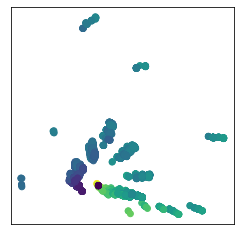

In [ ]:
plt.figure(figsize = (4,4))
plt.scatter(x[:, 0], x[:, 1], c = Y)
plt.xticks([])
plt.yticks([])
plt.savefig("eigen.pdf")
plt.show()